In [163]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
import sklearn
from sklearn.model_selection import GridSearchCV

In [164]:
train_data = pd.read_pickle('../datasets/training_dictionary.pkl')
test_data = pd.read_pickle('../datasets/validation_dictionary.pkl')

In [321]:
train_data['GK'].out_result_id.value_counts(dropna=False)

out_result_id
727    11
452    11
723    11
490    10
307    10
       ..
801     1
761     1
814     1
397     1
407     1
Name: count, Length: 1038, dtype: int64

In [289]:
test_data['GK'].columns.to_list()

['index_0',
 'id_0',
 'player_team_0',
 'opponent_0',
 'points_0',
 'goals_0',
 'assists_0',
 'bonus_0',
 'conceded_0',
 'minutes_0',
 'player_id_0',
 'result_id_0',
 'fixture_id_0',
 'clean_sheets_0',
 'own_goals_0',
 'penalties_saved_0',
 'penalties_missed_0',
 'yellow_cards_0',
 'red_cards_0',
 'saves_0',
 'bps_0',
 'influence_0',
 'creativity_0',
 'threat_0',
 'ict_index_0',
 'expected_goals_0',
 'expected_assists_0',
 'expected_goal_involvements_0',
 'expected_goals_conceded_0',
 'datetime_0',
 'team_G_0',
 'team_Gc_0',
 'p_att_0',
 'p_mid_0',
 'p_defn_0',
 'p_ovr_0',
 'o_att_0',
 'o_mid_0',
 'o_defn_0',
 'o_ovr_0',
 'index_1',
 'id_1',
 'player_team_1',
 'opponent_1',
 'points_1',
 'goals_1',
 'assists_1',
 'bonus_1',
 'conceded_1',
 'minutes_1',
 'player_id_1',
 'result_id_1',
 'fixture_id_1',
 'clean_sheets_1',
 'own_goals_1',
 'penalties_saved_1',
 'penalties_missed_1',
 'yellow_cards_1',
 'red_cards_1',
 'saves_1',
 'bps_1',
 'influence_1',
 'creativity_1',
 'threat_1',
 'ict

In [329]:
test_data['GK'].out_player_team.value_counts(dropna=False)

out_player_team
WOL    219
AVL    186
ARS    160
CRY    157
BOU    151
NFO    129
BRE    126
CHE    105
MCI    103
LIV    103
BHA     69
LEI     68
LUT     67
MUN     47
NEW     44
LEE     34
IPS     33
Name: count, dtype: int64

In [166]:
# data_sorted = data.sort_values(by=['player', 'date']).reset_index()

In [167]:
print(get_cols(train_data['GK'], 'points_'))

['points_0', 'points_1', 'points_2', 'points_3']


In [255]:
run_config = {'train_features': ['minutes_'],
              'target_feature': 'out_minutes'
}

def get_cols(df, substring):
    return [col for col in df.columns if substring in col]

# print(get_cols(train_data['GK'], 'bonus'))

def get_features(df, substrings):
    features = []
    for substring in substrings:
        features.extend(get_cols(df, substring))
    return features

# get_features(train_data['GK'], ['minutes', 'bonus'])

def get_metrics(labels, predictions):
    rmse = root_mean_squared_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    errors = {'rmse': rmse, 'mae': mae, 'mse': mse}
    return errors

In [256]:
# get_features(test_data[run_config['position']], run_config['train_features'])

In [294]:
def main(config_dct, positions):

    errors_dct = {}
    models_dct = {}
    results_dct = {}
    for position in positions:
        print(f'Running model for {position}')
        train_feats = get_features(train_data[position], config_dct['train_features'])
        train_feats = [feat for feat in train_feats if 'out_' not in feat]
        print(train_feats)
        train_X = train_data[position][train_feats]
        print(len(train_X))
        train_y = train_data[position][config_dct['target_feature']]
        test_X = test_data[position][train_feats]
        print(len(test_X))
        test_y = test_data[position][config_dct['target_feature']]

        model = XGBRegressor(objective='reg:absoluteerror', n_estimators=5000, learning_rate=0.1, max_depth=2, eval_metric='mae', early_stopping_rounds=50, random_state=1) 

        model.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)], verbose=10)

        predictions = model.predict(test_X)

        errors = get_metrics(test_y, predictions)

        errors_dct[position] = errors
        models_dct[position] = model

        results_df = test_data[position][['out_player_id', 'out_datetime']]
        results_df['minutes'] = test_y
        results_df['predmins']= predictions
        results_df.columns = ['player_id', 'datetime', 'minutes', 'predmin']
        results_dct[position] = results_df

    return models_dct, errors_dct, results_dct



In [298]:
models, errors, results = main(run_config, ['GK','DEF', 'MID', 'FWD'])
errors

Running model for GK
['minutes_0', 'minutes_1', 'minutes_2', 'minutes_3']
5805
1801
[0]	validation_0-mae:19.95487	validation_1-mae:28.95280
[10]	validation_0-mae:9.31763	validation_1-mae:14.20824
[20]	validation_0-mae:5.66704	validation_1-mae:9.20915
[30]	validation_0-mae:4.40037	validation_1-mae:7.47183
[40]	validation_0-mae:3.95963	validation_1-mae:6.86833
[50]	validation_0-mae:3.80595	validation_1-mae:6.65790
[60]	validation_0-mae:3.75237	validation_1-mae:6.58453
[70]	validation_0-mae:3.73369	validation_1-mae:6.55895
[80]	validation_0-mae:3.72717	validation_1-mae:6.55003
[90]	validation_0-mae:3.72490	validation_1-mae:6.54692
[100]	validation_0-mae:3.72411	validation_1-mae:6.54583
[110]	validation_0-mae:3.72383	validation_1-mae:6.54545
[120]	validation_0-mae:3.72374	validation_1-mae:6.54532
[130]	validation_0-mae:3.72370	validation_1-mae:6.54528
[140]	validation_0-mae:3.72369	validation_1-mae:6.54526
[150]	validation_0-mae:3.72369	validation_1-mae:6.54526
[160]	validation_0-mae:3.723

/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['minutes'] = test_y
/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['predmins']= predictions


[100]	validation_0-mae:12.33878	validation_1-mae:13.64122
[110]	validation_0-mae:12.33856	validation_1-mae:13.64105
[120]	validation_0-mae:12.33848	validation_1-mae:13.64099
[130]	validation_0-mae:12.33845	validation_1-mae:13.64097
[140]	validation_0-mae:12.33844	validation_1-mae:13.64096
[150]	validation_0-mae:12.33844	validation_1-mae:13.64096
[160]	validation_0-mae:12.33844	validation_1-mae:13.64096
[170]	validation_0-mae:12.33844	validation_1-mae:13.64096
[180]	validation_0-mae:12.33844	validation_1-mae:13.64096
[190]	validation_0-mae:12.33844	validation_1-mae:13.64096
[200]	validation_0-mae:12.33844	validation_1-mae:13.64096
[210]	validation_0-mae:12.33844	validation_1-mae:13.64096
[220]	validation_0-mae:12.33844	validation_1-mae:13.64096
[230]	validation_0-mae:12.33844	validation_1-mae:13.64096
[240]	validation_0-mae:12.33844	validation_1-mae:13.64096
[250]	validation_0-mae:12.33844	validation_1-mae:13.64096
[260]	validation_0-mae:12.33844	validation_1-mae:13.64096
[270]	validati

/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['minutes'] = test_y
/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['predmins']= predictions


[70]	validation_0-mae:12.53535	validation_1-mae:11.67781
[80]	validation_0-mae:12.53390	validation_1-mae:11.67617
[90]	validation_0-mae:12.53339	validation_1-mae:11.67560
[100]	validation_0-mae:12.53321	validation_1-mae:11.67540
[110]	validation_0-mae:12.53315	validation_1-mae:11.67533
[120]	validation_0-mae:12.53313	validation_1-mae:11.67531
[130]	validation_0-mae:12.53312	validation_1-mae:11.67530
[140]	validation_0-mae:12.53312	validation_1-mae:11.67529
[150]	validation_0-mae:12.53312	validation_1-mae:11.67529
[160]	validation_0-mae:12.53312	validation_1-mae:11.67529
[170]	validation_0-mae:12.53312	validation_1-mae:11.67529
[180]	validation_0-mae:12.53312	validation_1-mae:11.67529
[190]	validation_0-mae:12.53312	validation_1-mae:11.67529
[200]	validation_0-mae:12.53312	validation_1-mae:11.67529
[210]	validation_0-mae:12.53312	validation_1-mae:11.67529
[220]	validation_0-mae:12.53312	validation_1-mae:11.67529
[230]	validation_0-mae:12.53312	validation_1-mae:11.67529
[240]	validation_

/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['minutes'] = test_y
/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['predmins']= predictions
/var/folders/yg/bqmyvbx95n374k1c8rnvgdhm0000gr/T/ipykernel_97920/766014334.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

{'GK': {'rmse': 23.685564041137695,
  'mae': 6.545260906219482,
  'mse': 561.0059204101562},
 'DEF': {'rmse': 29.17487144470215,
  'mae': 13.640890121459961,
  'mse': 851.173095703125},
 'MID': {'rmse': 22.92316246032715,
  'mae': 11.675236701965332,
  'mse': 525.4713745117188},
 'FWD': {'rmse': 24.04948616027832,
  'mae': 13.198800086975098,
  'mse': 578.3777465820312}}

In [305]:
results['GK'].to_csv('../results/xgboost_GK.csv', index=False)
results['DEF'].to_csv('../results/xgboost_DEF.csv', index=False)
results['MID'].to_csv('../results/xgboost_MID.csv', index=False)
results['FWD'].to_csv('../results/xgboost_FWD.csv', index=False)

In [310]:
len(results['FWD'])

1454

In [287]:
errors_df = pd.DataFrame(errors)
errors_df

,GK,DEF,MID,FWD
rmse,23.685564,29.174871,22.923162,24.049486
mae,6.545261,13.640890,11.675237,13.198800
mse,561.005920,851.173096,525.471375,578.377747


In [288]:
# gks_train = train_data['GK']
# defs_train = train_data['DEF']
# mids_train = train_data['MID']
# fwds_train = train_data['FWD']
# full_train = pd.concat([gks_train, defs_train, mids_train, fwds_train], axis=0).reset_index()
# assert len(full_train) == len(gks_train) + len(defs_train) + len(mids_train) + len(fwds_train)

# X_train = full_train[get_features(full_train, run_config['train_features'])]
# y_train = full_train[run_config['target_feature']]

# gks_test = test_data['GK']
# defs_test = test_data['DEF']
# mids_test = test_data['MID']
# fwds_test = test_data['FWD']
# full_test = pd.concat([gks_test, defs_test, mids_test, fwds_test], axis=0).reset_index()
# assert len(full_test) == len(gks_test) + len(defs_test) + len(mids_test) + len(fwds_test)

# X_train = full_train[get_features(full_train, run_config['train_features'])]
# y_train = full_train[run_config['target_feature']]

In [111]:
get_features(full_train, run_config['train_features'])

['minutes_0',
 'minutes_1',
 'minutes_2',
 'minutes_3',
 'points_0',
 'points_1',
 'points_2',
 'points_3']

In [317]:
# params_grid = {'n_estimators': [1000, 3000, 5000, 10000],
#                'learning_rate': [0.01, 0.05, 0.1, 0.2],
#                 'max_depth': [2, 4, 6],
#                 'eval_metric': ['mae', 'rmse'],
#                 # 'early_stopping_rounds': [10, 30, 50]
#                 }

# model = XGBRegressor(objective='reg:squarederror', early_stopping_rounds=30)
# search = GridSearchCV(model, params_grid).fit(X_train, y_train)
# search.best_params_

## Looking for player correlations

In [319]:
positions = ['GK', 'DEF', 'MID', 'FWD']
full_dfs = {}
for position in positions:
    full_dfs[position] = pd.concat([train_data[position], test_data[position]], axis=0).reset_index(drop=True)
    

In [346]:
full_GK = full_dfs['GK']
full_DEF = full_dfs['DEF']
full_MID = full_dfs['MID']
full_FWD = full_dfs['FWD']

In [338]:
player_names = pd.read_csv('../results/Player_Id_to_Name.csv')
player_names.head()

,Unnamed: 0,player_id,fpl_api_id,name
0,0,1,NaN,Fábio Ferreira Vieira
1,1,2,NaN,Gabriel Fernando de Jesus
2,2,3,NaN,Gabriel dos Santos Magalhães
3,3,4,NaN,Kai Havertz
4,4,5,NaN,Karl Hein


In [347]:
full_DEF_clean = full_DEF[['out_player_id', 'out_fixture_id', 'out_player_team', 'out_opponent', 'out_minutes', 'name']]
full_FWD_clean = full_FWD[['out_player_id', 'out_fixture_id', 'out_player_team', 'out_opponent', 'out_minutes', 'name']]
full_MID_clean = full_MID[['out_player_id', 'out_fixture_id', 'out_player_team', 'out_opponent', 'out_minutes', 'name']]

In [348]:
full_DEF_clean.head()

,out_player_id,out_fixture_id,out_player_team,out_opponent,out_minutes,name
0,377,46,IPS,SOU,0,George Edmundson
1,377,58,IPS,AVL,0,George Edmundson
2,377,66,IPS,WHU,0,George Edmundson
3,377,76,IPS,EVE,0,George Edmundson
4,377,83,IPS,BRE,0,George Edmundson


In [343]:
for key, df in full_dfs.items():
    matched_df = pd.merge(df, player_names, left_on='out_player_id', right_on='player_id', how='left')
    full_dfs[key] = matched_df.drop(columns=['player_id'])

In [349]:
def pivot_minutes_by_opponent_per_team(df):
    """
    For each out_player_team, create a DataFrame with out_opponent as rows,
    out_player_id as columns, and values as mean out_minutes.
    Returns a dictionary: {team: DataFrame}
    """
    team_pivots = {}
    for team in df['out_player_team'].unique():
        team_df = df[df['out_player_team'] == team]
        pivot = team_df.pivot_table(
            index='out_fixture_id',
            columns='name',
            values='out_minutes',
            aggfunc='mean'
        )
        team_pivots[team] = pivot
    return team_pivots

# Example usage:
team_minutes_pivots = pivot_minutes_by_opponent_per_team(full_DEF_clean)
# Access a team's pivot: team_minutes_pivots['ARS'] (for example)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_player_minutes_correlation_heatmap(df, team_name):
    """
    Plot a heatmap of the player minutes correlation matrix for a given team.
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
    plt.title(f'Player Minutes Correlation Heatmap - {team_name}')
    plt.xlabel('Player ID')
    plt.ylabel('Player ID')
    plt.tight_layout()
    plt.show()

name,Ayden Heaven,Benjamin White,Cédric Alves Soares,Gabriel dos Santos Magalhães,Jakub Kiwior,James Sweet,Josh Nichols,Jurriën Timber,Kieran Tierney,Lino Sousa,Maldini Kacurri,Nuno Varela Tavares,Oleksandr Zinchenko,Pablo Marí Villar,Reuell Walters,Riccardo Calafiori,Rob Holding,Takehiro Tomiyasu,Tomiyasu Takehiro,William Saliba
name,,,,,,,,,,,,,,,,,,,,
Ayden Heaven,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Benjamin White,NaN,1.000000,-0.068630,0.108579,0.149394,NaN,NaN,-0.672397,0.065023,NaN,NaN,NaN,0.190553,NaN,NaN,0.326075,0.200348,-0.434881,NaN,-0.244783
Cédric Alves Soares,NaN,-0.068630,1.000000,0.057247,0.532719,NaN,NaN,-0.052338,-0.028195,NaN,NaN,NaN,0.149724,NaN,NaN,NaN,-0.124827,0.096999,NaN,-0.599166
Gabriel dos Santos Magalhães,NaN,0.108579,0.057247,1.000000,-0.225201,NaN,NaN,-0.110196,0.092652,NaN,NaN,NaN,0.116994,NaN,NaN,-0.037216,0.060833,-0.014159,0.074749,-0.010913
Jakub Kiwior,NaN,0.149394,0.532719,-0.225201,1.000000,NaN,NaN,-0.172268,0.253789,NaN,NaN,NaN,-0.173877,NaN,NaN,-0.076705,-0.436882,-0.307298,-0.134338,-0.148030
James Sweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Josh Nichols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jurriën Timber,NaN,-0.672397,-0.052338,-0.110196,-0.172268,NaN,NaN,1.000000,0.147281,NaN,NaN,NaN,-0.492349,NaN,NaN,-0.341520,NaN,0.263757,-0.309575,-0.021203
Kieran Tierney,NaN,0.065023,-0.028195,0.092652,0.253789,NaN,NaN,0.147281,1.000000,NaN,NaN,NaN,-0.066725,NaN,NaN,0.082002,0.000811,-0.172372,NaN,-0.264602


In [ ]:
tea

In [330]:
teams = full_GK.out_player_team.unique().tolist()

In [327]:
full_GK.out_player_team.value_counts()

out_player_team
AVL    538
CHE    475
MUN    415
BOU    410
TOT    376
ARS    373
CRY    373
WOL    372
LIV    372
NFO    371
NEW    370
MCI    349
BHA    348
BRE    327
WHU    318
SOU    304
EVE    303
FUL    279
LEI    268
BUR    171
LUT    169
SHU    116
IPS    108
LEE    101
Name: count, dtype: int64

# Modelling

In [4]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
import sklearn
from sklearn.model_selection import GridSearchCV

In [51]:
data_sorted.columns

Index(['index', 'Unnamed: 0', 'season', 'team', 'week', 'date', 'opponent',
       'home_or_away', 'outcome', 'player', 'injured_or_suspended', 'reason',
       'minutes', 'xG', 'xA', 'xGC', 'bps', 'goals', 'assists',
       'goals_conceded'],
      dtype='object')

In [49]:
# training_features = ['team', 'week', 'opponent', 'home_or_away', 'outcome', 'injured_or_suspended',
#                     'xG_1', 'xG_2', 'xG_3', 'xA_1', 'xA_2', 'xA_3', 'xGC_1', 'xGC_2', 'xGC_3',
#                     'minutes_1', 'minutes_2', 'minutes_3']

target_feature = 'minutes'

teams_out = ['LEI', 'EVE', 'CRY']
# metrics = [mae, rmse, mse]
# 5-steps

rolling_feats = ['minutes']
train_data = data_sorted[~data_sorted.team.isin(teams_out)]
test_data = data_sorted[data_sorted.team.isin(teams_out)]
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(df, rolling_cols, n_in, n_out=1, dropnan=True):
    cols = list()
    col_names = list()
	# input sequence (t-n, ... t-1)
    for col in rolling_cols:
        for i in range(n_in, 0, -1):
            cols.append(df[col].shift(i))
            col_names.append(f'previous_{col}_{i}')
    	# forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df[col].shift(-i))
            col_names.append(f'future_{col}_{i}')
    	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = col_names
    	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:
train = series_to_supervised(train_data, ['minutes'],n_in=2)
train.head()

,previous_minutes_2,previous_minutes_1,future_minutes_0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0
5,0.0,0.0,0
6,0.0,0.0,0


In [ ]:
series_to_supervised

In [101]:
# train = series_to_supervised(train_data.minutes)
# test = series_to_supervised(test_data.minutes)

In [103]:
# test

array([[62., 56.,  7.,  0., 90., 90.],
       [56.,  7.,  0., 90., 90., 90.],
       [ 7.,  0., 90., 90., 90., 90.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], shape=(3792, 6))

In [61]:
train_1 = series_to_supervised(train_data, ['minutes', 'bps'], n_in=5)
# test_1 = series_to_supervised(test_data, ['minutes'], n_in=5)
train_1

,previous_minutes_5,previous_minutes_4,previous_minutes_3,previous_minutes_2,previous_minutes_1,future_minutes_0,previous_bps_5,previous_bps_4,previous_bps_3,previous_bps_2,previous_bps_1,future_bps_0
5,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27278,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
27279,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
27280,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
27281,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [62]:
train_1.columns

Index(['previous_minutes_5', 'previous_minutes_4', 'previous_minutes_3',
       'previous_minutes_2', 'previous_minutes_1', 'future_minutes_0',
       'previous_bps_5', 'previous_bps_4', 'previous_bps_3', 'previous_bps_2',
       'previous_bps_1', 'future_bps_0'],
      dtype='object')

In [74]:
# walk-forward validation for univariate data
def walk_forward_validation(train, test):
    predictions = list()
    # split dataset
    trainX, trainy = train.iloc[:, :-1], train['future_minutes_0']
    colls_keep = [col for col in trainX.columns if 'previous' in col]
    trainX = trainX[colls_keep]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1, max_depth=4)
    model.fit(trainX, trainy)
    # step over each time-step in the test set
    for i in range(len(test)):
    	# split test row into input and output columns
        testX, testy = test.iloc[i, :-1], test['future_minutes_0']
        testX = testX[colls_keep]
        # fit model on history and make a prediction
        yhat = model.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        # history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    rmse = root_mean_squared_error(test[:, -1], predictions)
    mse = mean_squared_error(test[:, -1], predictions)
    errors = [mae, rmse, mse]
    return errors, test[:, 1], predictions, model

In [65]:
colls_keep = [col for col in train_1.columns if 'previous' in col]
colls_keep

['previous_minutes_5',
 'previous_minutes_4',
 'previous_minutes_3',
 'previous_minutes_2',
 'previous_minutes_1',
 'previous_bps_5',
 'previous_bps_4',
 'previous_bps_3',
 'previous_bps_2',
 'previous_bps_1']

In [105]:
def xgboost_forecast(train, testX):
	# transform list into array
    train = np.asarray(train)
	# split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1, max_depth=4)
    model.fit(trainX, trainy)
	# make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [110]:
errors, y, yhat, model = walk_forward_validation(train, test)

In [75]:
run_dct = {'benchmark': ['minutes'],
           'bps': ['minutes', 'bps'],
           'bps_outcome': ['minutes', 'bps', 'outcome']}

In [76]:
def main(run):
    train = series_to_supervised(train_data, run_dct[run], n_in=6)
    test = series_to_supervised(test_data, run_dct[run], n_in=6)
    errs, test_res, preds, model = walk_forward_validation(train, test)
    # feature_names = [f'feature_{i}' for i in range(train.shape[1])]
    features = model.get_booster().feature_names
    return errs, model.feature_importances_, features

In [77]:
errs_dct = {}
importances_dct = {}
features_dct = {}
for run in run_dct.keys():
    errs, importance, features = main(run)
    errs_dct[run] = errs
    importances_dct[run] = importance
    features_dct[run] = features

InvalidIndexError: (slice(None, None, None), -1)

In [17]:
# def main(n_in):
#     train = series_to_supervised(train_data.minutes, n_in)
#     test = series_to_supervised(test_data.minutes, n_in)
#     errs, test_res, preds, model = walk_forward_validation(train, test)
#     # print(n_in)
#     # print(errs)
#     # print(model.feature_importances_)
#     # print('/n')
#     return errs, model.feature_importances_

In [67]:
# feats = {}
# errs = {}
# for n_in in range(1,11):
#     errors, features = main(n_in)
#     errs[n_in] = errors
#     feats[n_in] = features

KeyError: 1

In [23]:
errors_df = pd.DataFrame(errs).T

In [26]:
errors_df.columns = ['mae', 'rmse', 'mse']

<Axes: >

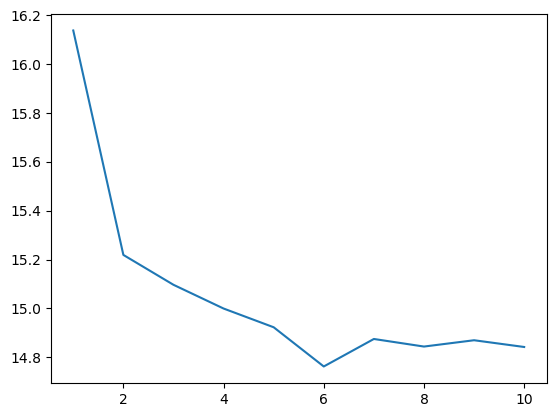

In [30]:
errors_df.mae.plot(kind='line')

In [112]:
import matplotlib.pyplot as plt

In [116]:
errors

[14.922681169714071, 23.972344480806747, 574.6732999064658]

<BarContainer object of 5 artists>

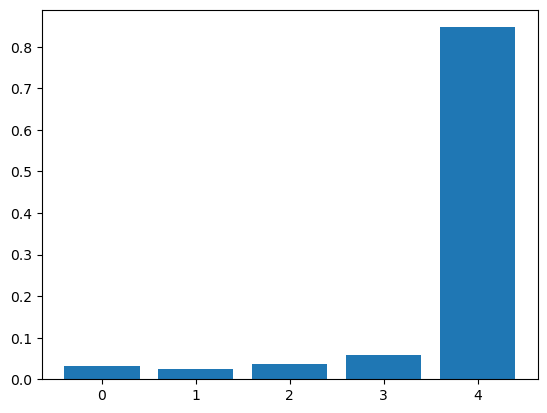

In [115]:
# training_features = ['team', 'week', 'opponent', 'home_or_away', 'outcome', 'injured_or_suspended',
#                     'xG_1', 'xG_2', 'xG_3', 'xA_1', 'xA_2', 'xA_3', 'xGC_1', 'xGC_2', 'xGC_3',
#                     'minutes_1', 'minutes_2', 'minutes_3']
# target_feature = 'minutes'
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [51]:
# Split features and target
X = updated_data[training_features]
y = updated_data[target_feature]

# Optional: Encode categorical features
X = pd.get_dummies(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
# model = XGBRegressor(n_estimators=400, learning_rate=0.2, max_depth=5, random_state=42)
model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Mean Absolute Error: 14.07
Root Mean Squared Error: 23.49


In [40]:
y_pred[:10]

array([77.10226   ,  8.237777  ,  0.94490016, 78.52525   , 16.324774  ,
       55.912975  ,  3.1651833 , 39.07936   ,  3.1084614 , 47.82977   ],
      dtype=float32)

In [41]:
y_test[:10]

19417    71
3216      0
26875     0
26694    90
23303    79
13898    63
13742     0
15611     0
16752    90
13291    87
Name: minutes, dtype: int64

In [48]:
regressor = XGBRegressor(eval_metric='mae')
param_grid = {"max_depth":  [4, 6, 10],
           "n_estimators": [200, 500, 800],
           "learning_rate": [0.01, 0.02, 0.05]}

search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [315]:
# test = pd.read_csv('/Users/cvlahos/Downloads/player_minutes_with_extra_columns_2425.csv')

In [316]:
# test[test.player == 'Bukayo Saka']